## Dataset Used: intermediate.jsoncel from ocpa github sample logs

In [1]:
#make a readme and a requirements file

# Importing Event Log 


In [2]:
import ocpa
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
filename = "intermediate.jsonocel"
ocel = ocel_import_factory.apply(filename)

# the filetype of the datasets posted on the ocel website does not match the ocpm documentation input filetype
# json vs jsonocel

# Process Discovery


In [3]:
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.visualization.oc_petri_net import factory as ocpn_vis_factory
ocpn = ocpn_discovery_factory.apply(ocel, parameters={"debug": False})
ocpn_vis_factory.save(ocpn_vis_factory.apply(ocpn), "oc_petri_net.png")

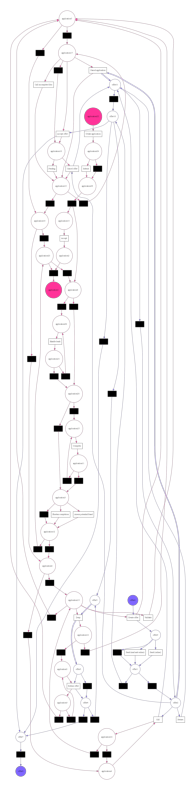

In [4]:
#view the ocpm petri net
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# cannot increase the size of image here, tried out matplotlib and graphviz paramtere tuning
img = mpimg.imread("oc_petri_net.png")
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [5]:
#variant calculation and layouting
#The variant layouting just returns a positioning of chevrons as coordinates.
#Instead of drawing the entire process flow directly, the layout algorithm only computes coordinates (X, Y positions) for these elements, 
#so they can be plotted or displayed.


from ocpa.visualization.log.variants import factory as variants_visualization_factory
print("Number of process executions: "+str(len(ocel.process_executions)))
print("Number of variants: "+str(len(ocel.variants)))
variant_layouting = variants_visualization_factory.apply(ocel)
print(variant_layouting[ocel.variants[0]])

Number of process executions: 1000
Number of variants: 917
([['Accept offer', [[11, 11], [0, 1]]], ['Pending', [[12, 12], [0]]], ['Cancel offer', [[13, 13], [0, 2]]], ['Cancel offer', [[14, 14], [0, 3]]], ['Cancel offer', [[15, 15], [0, 4]]], ['Create offer', [[6, 6], [0, 2]]], ['Create offer', [[7, 7], [0, 1]]], ['Send (mail and online)', [[8, 8], [1]]], ['Send (mail and online)', [[7, 12], [2]]], ['Create application', [[0, 0], [0]]], ['Accept', [[1, 1], [0]]], ['Create offer', [[2, 2], [0, 4]]], ['Send (mail and online)', [[3, 3], [4]]], ['Complete', [[3, 3], [0]]], ['Call', [[4, 4], [4, 0]]], ['Create offer', [[5, 5], [0, 3]]], ['Send (mail and online)', [[6, 13], [3]]], ['Validate', [[8, 8], [0]]], ['Return', [[9, 10], [1]]], ['Call incomplete files', [[9, 9], [0]]], ['Validate', [[10, 10], [0]]]], {0: ('application', 'application_1'), 1: ('offer', 'offer_1'), 2: ('offer', 'offer_2'), 3: ('offer', 'offer_3'), 4: ('offer', 'offer_4')})


Hard to display 917 variants, checked on the variant explorer in ocpi
Only 2 objects , application and offer , only seen application 1 but multiple offers (offer1, offer 2... 5)

# Precision and Fitness

In [ ]:
from ocpa.algo.conformance.precision_and_fitness import evaluator as quality_measure_factory

precision, fitness = quality_measure_factory.apply(ocel, ocpn)
print("Precision of IM-discovered net: "+str(precision))
print("Fitness of IM-discovered net: "+str(fitness))
#too long compilation, going over an hour and still no output (maybe cause of the flattening>metrics>combining)

# Filtered Log

Filtering variants as precision and fitness gets stuck in a never ending compile loop

#from ocpa.examplescripts.eventlogmanagement.misc.filter_variants
# 20% of infrequent variants filtered out

from ocpa.algo.util.filtering.log.variant_filtering import filter_infrequent_variants
from ocpa.algo.util.process_executions.factory.LEAD_TYPE 
object_types = ["application", "offer"]
parameters = {"obj_names": object_types,
              "val_names": [],
              "act_name": "event_activity",
              "time_name": "event_timestamp",
              "sep": ",",
              "execution_extraction": ocpa.algo.util.process_executions.factory.LEAD_TYPE,
              "leading_type": object_types[0],
              "variant_calculation": ocpa.algo.util.variants.factory.TWO_PHASE}
ocel_fil = ocel_import_factory.apply(file_path=filename, parameters=parameters)
filtered = filter_infrequent_variants(ocel_fil, 0.2)

In [ ]:
from ocpa.objects.log.util import misc as log_util


def filter_infrequent_variants(ocel, threshold):
    '''
    Filters infrequent variants from an OCEL

    :param ocel: Object-centric event log
    :type ocel: :class:`OCEL <ocpa.objects.log.ocel.OCEL>`

    :param threshold: Cumulative frequency of the most frequent variants to be included.
    :type threshold: float

    :return: Object-centric event log
    :rtype: :class:`OCEL <ocpa.objects.log.ocel.OCEL>`

    '''
    ocel = log_util.copy_log(ocel)
    if threshold > 0.9999:
        return ocel
    v_freq_acc = [sum(ocel.variant_frequencies[0:i+1])
                  for i in range(0, len(ocel.variant_frequencies))]
    last_filtered_variant = len(v_freq_acc)-1
    filtered_variants = []
    for i in range(0, len(v_freq_acc)):
        filtered_variants.append(i)
        if v_freq_acc[i] > threshold:
            last_filtered_variant = i
            break
    # get the relevant objects
    rel_obs = log_util.get_objects_of_variants(ocel, filtered_variants)
    pref_sublog = log_util.remove_object_references(
        ocel.log.log, ocel.object_types, rel_obs)
    sublog = pref_sublog[pref_sublog["event_variant"].apply(
        lambda x: bool(set(x) & set(filtered_variants)))].copy()
    sublog = sublog.drop("event_variant", axis=1)
    sublog = log_util.remove_object_references(
        sublog, ocel.object_types, rel_obs)
    new_log = log_util.copy_log_from_df(sublog, ocel.parameters)
    return new_log

filtered2= filter_infrequent_variants(ocel,0.1)
#anything higher than 0.1 doesnt work

Filtered Process Discovery

In [8]:
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.visualization.oc_petri_net import factory as ocpn_vis_factory

ocpn_fil = ocpn_discovery_factory.apply(filtered2, parameters={"debug": False})
print(type(ocpn_fil))  # Should be an OCPN object, not OCEL



<class 'ocpa.objects.oc_petri_net.obj.ObjectCentricPetriNet'>


In [9]:
ocpn_vis_factory.save(ocpn_vis_factory.apply(ocpn_fil), "oc_petri_net_fil2.png")

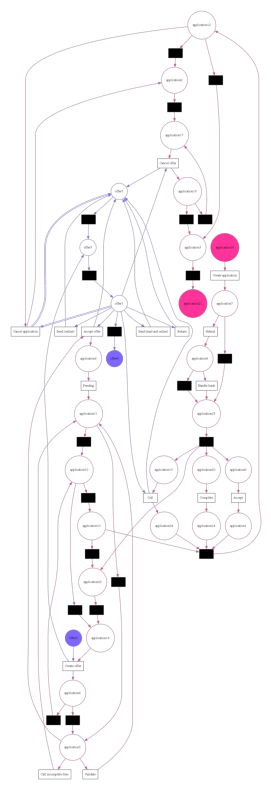

In [10]:
img = mpimg.imread("oc_petri_net_fil2.png")
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
from ocpa.algo.conformance.precision_and_fitness import evaluator as quality_measure_factory

precision, fitness = quality_measure_factory.apply(filtered2, ocpn_fil)
print("Precision of IM-discovered net: "+str(precision))
print("Fitness of IM-discovered net: "+str(fitness))
# need to work to better precision


Precision of IM-discovered net: 0.3330563006778694
Fitness of IM-discovered net: 1.0


In [12]:
from ocpa.objects.log.exporter.ocel import factory as ocel_export_factory
ocel_export_factory.apply(
    filtered2, './filtered-intermediate.jsonocel')

{'ocel:global-log': {'ocel:attribute-names': ['event_id'],
  'ocel:object-types': ['offer', 'application'],
  'ocel:version': '1.0',
  'ocel:ordering': 'timestamp'},
 'ocel:global-event': {'ocel:activity': '__INVALID__'},
 'ocel:global-object': {'ocel:type': '__INVALID__'},
 'ocel:events': {'7': {'ocel:activity': 'Create application',
   'ocel:timestamp': '2016-01-02T21:20:30.638000',
   'ocel:omap': ['Application_1825104006'],
   'ocel:vmap': {'event_id': 7,
    'start_timestamp': Timestamp('2016-01-02 21:20:30.638000')}},
  '8': {'ocel:activity': 'Submit',
   'ocel:timestamp': '2016-01-02T21:20:30.682000',
   'ocel:omap': ['Application_1825104006'],
   'ocel:vmap': {'event_id': 8,
    'start_timestamp': Timestamp('2016-01-02 21:20:30.682000')}},
  '26': {'ocel:activity': 'Complete',
   'ocel:timestamp': '2016-01-04T11:18:26.275000',
   'ocel:omap': ['Application_1825104006'],
   'ocel:vmap': {'event_id': 26,
    'start_timestamp': Timestamp('2016-01-04 11:18:26.275000')}},
  '36': {'

# Process Analysis

In [ ]:
#search for performance factory in the package, this code was taken from ocpm documentation
diag_params = {'measures': ['act_freq', 'arc_freq', 'object_count', 'waiting_time', 'service_time', 'sojourn_time', 'synchronization_time', 'pooling_time', 'lagging_time', 'flow_time'], 'agg': [
    'mean', 'min', 'max'], 'format': 'svg'}
diag = performance_factory.apply(ocpn_fil, filtered2, parameters=diag_params)
print(f'Diagnostics: {diag}')
gviz = ocpn_vis_factory.apply(
    ocpn_fil, diagnostics=diag, variant="annotated_with_opera", parameters=diag_params)
ocpn_vis_factory.view(gviz)

NameError: name 'performance_factory' is not defined

References:

https://ocpa.readthedocs.io/en/latest/index.html

https://github.com/ocpm/ocpa

https://ocpi.ai/#about